In [1]:
#EP Phys 512
#Question 4

In [2]:
import numpy as np
import matplotlib.pyplot as mpl
from wmap_camb_example import get_spectrum
import corner

In /home/elizabeth/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/elizabeth/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/elizabeth/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/elizabeth/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/elizabeth/.local/lib/python3.6/site-packages/matplo

#### METHODS USED:

##### MCMC with Cholesky
The final method I used was running the MCMC drawing the distributions using the Cholesky of the inverse of the curvature matrix generated in Question 3.

Two different versions of the curvature matrix were used:
    1. One generated with the information of 5 parameters without tau, then with the tau information added in afterwards.
    2. One generated with all 6 parameters at once.

Using the first curvature matrix gave the desired step size of As of about $10^{11}$ and resulted in a really nice (~0.25) acceptance rate. All of the chains converged really nicely - except those for tau and As, which didn't really converge, or at the least have very few independent samples. Thhis actually also provided a better value for tau than the second chain.

Using the second curvature matrix gave an As step about $9*10^{-10}$ and resulted in a much smaller acceptance rate (~0.07) and most parameters didn't converge as nicely - except tau and As actually converged better by visual inspection of the chains. This is probably because generating the curvature matrix with all 6 parameters as once gives all the correlation information between tau and As and that helps it pick out steps that are good for those two parameters.

##### MCMC with step sizes

The other approach I tried was using the std() of one of the cholesky chains to create new step sizes to feed into the MCMC. However, this approach took too long to converge. Cholesky is definitely better.



In [3]:
#some useful functions

#providing chi2 for the data
def chi2(data, pars):
    ypred = get_spectrum(pars)
    ypred = ypred[2:1199+2] #chop down to correct size
    return np.sum( (data[:,1] - ypred)**2/data[:,2]**2 ) #wmap[:,1] =data , 2=std on data point


def acceptance_rate(chain):
    count = sum( (chain[1:, 0] - chain[0:-1, 0] ) != 0)
    acc_rate = count/chain.shape[0]
    print('total count is ', count)
    print('length of chain is ', chain.shape[0])
    print('acceptance rate is ', acc_rate)
    return acc_rate

#uses cholesky matrix to draw step sizes
#diagnostics about how many times tau is prevented from going negative slow program a little
# but it's worth it for the sanity check.
#right now re-tries steps that make tau go negative without counting as rejected steps
def markov_cholesky(pars, wmap, r, chi2fun, n):
    count_neg_tau = 0
    count_iters = 0
    count_accept = 0

    #create data holding members
    npar = len(pars)
    chain = np.zeros([n, npar]) #track each step for each parameter in chain
    chi2vec = np.zeros(n) #keep track of chi2 at each step

    #calculate chi2 to determine step condition
    chi2_cur = chi2fun(wmap,pars)
    print('our current chi2 value is ', chi2_cur)

    #do actual chain calculations
    ii = int(0)
    while ii < n: #for ii in range(n): #switch to while loop - need to be able to redo iterations
        count_iters += 1 #sanity check that redos happen as often as I think they do and not more
        pars_trial = pars + np.dot(r, np.random.randn(r.shape[0])) #add dist drawn from cholesky
        if pars_trial[3] > 0: #only go forward if tau is positive, can't be negative
            #for super long runs can run off edge of possibility, breaking get_spectrum()
            #shouldn't be in probability space because probability is zero. shouldn't be sampled.
            #try again and don't count as a step. note try/except will slow program.
            try:
                chi2_trial = chi2fun(wmap, pars_trial) #check what chi2 value that would give
            except:
                #only infinite loop if parameters infinitely choose badly enough to break get_spectrum.
                #parameters should be able to step back to viable parameters from whence they came
                #so infinite loop unlikely
                print('OH NO your parameters probably broke get_spectrum. try again, don\'t count as step')
                ii = ii-1
                continue
            accept_prob = np.exp(-0.5*(chi2_trial - chi2_cur)) #prob that we take step
            if np.random.rand(1) < accept_prob: #take step
                pars=pars_trial
                chi2_cur = chi2_trial
                count_accept += 1
            #only be updated for cases where tau was positive.
            chain[ii, :] = pars #keep track of where we've been
            chi2vec[ii]=chi2_cur
        else: #tau was negative. REDO THE STEP.
            count_neg_tau += 1
            ii -= 1 #REDO THIS STEP.
    
        ii += 1 #INCREMENT WHILE LOOP. OR NEVER LEAVE ALIVE

    print('finished chain. ', count_neg_tau, ' steps were redone to maintain tau>0')
    print('total number of iterations done including redo steps are ', count_iters)
    print('total number of steps accepted were ', count_accept)
    return chain, chi2vec

def markov_stepsize(pars, wmap, par_step, chi2fun, n):
    count_neg_tau = 0

    #create data holding members
    npar = len(pars)
    chain = np.zeros([n, npar]) #track each step for each parameter in chain
    chi2vec = np.zeros(n) #keep track of chi2 at each step

    #calculate chi2 to determine step condition
    chi2_cur = chi2fun(wmap,pars)
    print('our current chi2 value is ', chi2_cur)

    #do actual chain calculations
    for ii in range(n):
        pars_trial = pars+np.random.randn(npar)*par_step #randomly add to each parameters
        if pars_trial[3] > 0: #only go forward if tau is positive, can't be negative
            chi2_trial = chi2fun(wmap, pars_trial) #check what chi2 value that would give
            accept_prob = np.exp(-0.5*(chi2_trial - chi2_cur)) #prob that we take step
            if np.random.rand(1) < accept_prob: #take step
                pars=pars_trial
                chi2_cur = chi2_trial
        else: #tau was negative.
            count_neg_tau += 1
        chain[ii, :] = pars #keep track of where we've been
        chi2vec[ii]=chi2_cur
    #     print('iter ', ii, ' pars ', pars)
    #     print('chi2_cur ', chi2_cur)
    print('finished chain. ', count_neg_tau, ' steps rejected to maintain tau>0')
    return chain, chi2vec

In [4]:
# STEP 0: SET UP BASIC PARAMETERS

wmap=np.loadtxt('wmap_tt_spectrum_9yr_v5.txt') #this is the data

#use best fit parameters from previous section 3 as starting point
pars = np.asarray([6.93351658e+01, 2.24911838e-02, 1.13886400e-01, 5.00000000e-02,
 2.04230773e-09, 9.69783026e-01])

#testing cholesky to see what step sizes will result
#for the matrix where all 6 parameters were generated at once
mat = np.loadtxt('newton_lhs.txt')
r = np.linalg.cholesky(np.linalg.inv(mat)) #create cholesky matrix for generating pars
print('matrix used calculated all parameters together :', mat)
print('ok so looking for ampl steps ', np.dot(r, np.ones(r.shape[0])) )

#for the matrix where 5 params and tau were done seperately
mat2 = np.loadtxt('lhs_tot.txt')
r2 = np.linalg.cholesky(np.linalg.inv(mat2)) #create cholesky matrix for generating pars
print('\n')
print('matrix used calculated tau afterwards and inserted it (and some zeros for filler ) :', mat2)
print('ok so looking for ampl steps ', np.dot(r2, np.ones(r2.shape[0])) )

#As for all 6 at once ~10^-9, for tau and other 5 done seperately As ~10^-11

matrix used calculated all parameters together : [[ 2.28705440e+00 -3.63357567e+03  1.21766508e+03  2.10081210e+02
  -5.17480706e+10  2.88360048e+01]
 [-3.63357567e+03  1.78671795e+07 -1.95496174e+06 -2.23827467e+05
   5.63009769e+13 -4.55138632e+05]
 [ 1.21766508e+03 -1.95496174e+06  1.78276276e+06  6.52030015e+05
  -1.62700934e+14  1.70232652e+05]
 [ 2.10081210e+02 -2.23827467e+05  6.52030015e+05  2.88208465e+05
  -7.20084829e+13  7.07826253e+04]
 [-5.17480706e+10  5.63009769e+13 -1.62700934e+14 -7.20084829e+13
   1.80033918e+22 -1.79686572e+13]
 [ 2.88360048e+01 -4.55138632e+05  1.70232652e+05  7.07826253e+04
  -1.79686572e+13  4.05807522e+04]]
ok so looking for ampl steps  [ 3.90007977e+00  1.24911490e-03 -3.26609754e-03  2.22244934e-01
  9.14339276e-10  4.71127285e-02]


matrix used calculated tau afterwards and inserted it (and some zeros for filler ) : [[ 2.28705440e+00 -3.63357567e+03  1.21766508e+03  0.00000000e+00
  -5.17480706e+10  2.88360048e+01]
 [-3.63357567e+03  1.786717

In [5]:
if False: #if we want to fit using the cholesky matrix from part 3
    
    #generate cholesky matrix
    mat = np.loadtxt('lhs_tot.txt')
    r = np.linalg.cholesky(np.linalg.inv(mat)) #create cholesky matrix for generating pars

    n=20000
    chain, chi2vec = markov_cholesky(pars, wmap, r, chi2, n)
    print('finished cholesky chain with acceptance rate ', acceptance_rate(chain))

In [6]:
#if we want to fit using the information from a previous markov chain
if False:
    n=20000
    chain_old = np.loadtxt('chain36k_nozeros.txt')
    par_sigs_old = np.std(chain_old, axis=0)
    pars_old = np.mean(chain_old, axis = 0) #forgot to do this for 20000 points.
    print('old step sizes', par_sigs_old)
    
    #from examining the previous chain we find that the tau parameter step size is so large that it
    #often tries to send tau negative, which is rejected instantly, lowering our acceptance rate
    #this large step size is therefore unphysical. so in this instance I reduce the step size manually for tau.
    #NOTE: this did not work well. VERY much unconverged after 20000 points.
    
    par_sigs_old[3] = par_sigs_old[3]/10
    print('adjusting tau step, par_steps now ', par_sigs_old)
    
#     chain, chi2vec = markov_stepsize(pars, wmap, par_sigs_old, chi2, n) #ran this wrongly for 20000 points
    chain, chi2vec = markov_stepsize(pars_old, wmap, par_sigs_old, chi2, n)
    print('finished cholesky chain with acceptance rate ', acceptance_rate(chain))

In [7]:
#SAVE MARKOV CHAIN
#this will overwrite it
# np.savetxt("chain.txt", chain)
# np.savetxt("chi2vec.txt", chi2vec)

In [8]:
#load data

# chain = np.loadtxt("chain36k_nozeros.txt")
# chi2vec = np.loadtxt("chi2vec36k_nozeros.txt")

#in the case of the chain crashing partway remove extraneous zeros from end of chain
# zeros = int(np.sum(chi2vec==0))
# print('number of zeros are ', zeros)
# print('n-zeros ', n-zeros)
# chain = chain[0:-zeros, :]
# chi2vec = chi2vec[0:-zeros]

# # np.savetxt("chain36k_nozeros.txt", chain)
# # np.savetxt("chi2vec36k_nozeros.txt", chi2vec)

### MCMC Cholesky with tau done seperately for curvature matrix (20k samples)

chain sigmas are  [2.59600026e+00 5.79098261e-04 5.42025749e-03 3.61256320e-02
 1.48507793e-10 1.54588163e-02]
chain means are  [6.98699656e+01 2.26108853e-02 1.13187952e-01 6.36210917e-02
 2.10101288e-09 9.73973272e-01]

 FINAL VALUES: 
final value for par  h0  :  69.8699656434214  error:  2.5960002559326374
final value for par  wbh^2  :  0.022610885273044966  error:  0.0005790982609434201
final value for par  wch^2  :  0.11318795240274733  error:  0.0054202574915772515
final value for par  tau  :  0.06362109166915669  error:  0.03612563202446219
final value for par  As  :  2.1010128814676004e-09  error:  1.485077926475381e-10
final value for par  pwrlaw  :  0.9739732719588912  error:  0.015458816261259216


total count is  5430
length of chain is  20000
acceptance rate is  0.2715
the acceptance rate of the chain is  0.2715


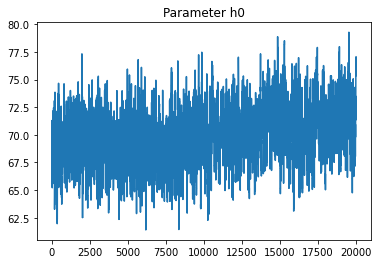

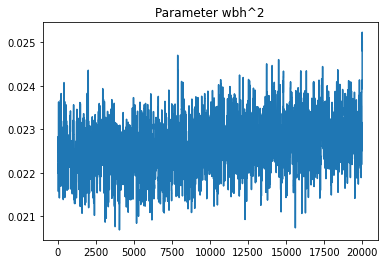

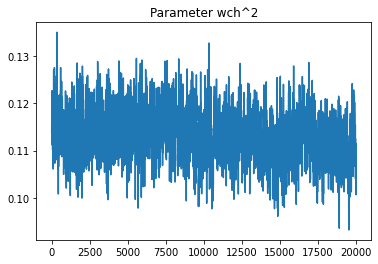

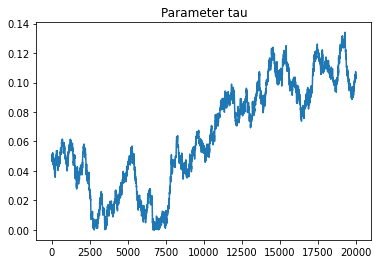

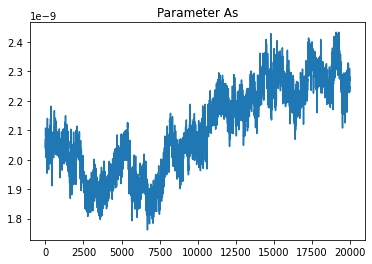

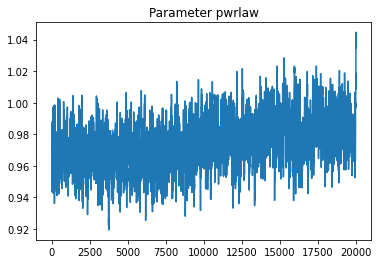

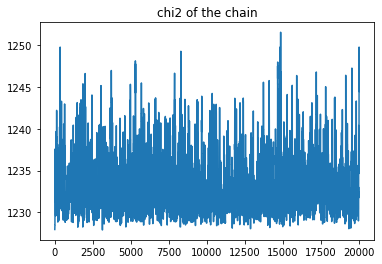

In [9]:
chain = np.loadtxt("chain20k_tauseperate.txt")
chi2vec = np.loadtxt("chi2vec20k_tauseperate.txt")

chainmeans = np.mean(chain, axis=0)
chainsigs = np.std(chain, axis=0)
print('chain sigmas are ', chainsigs)
print('chain means are ', chainmeans)

par_lab = ['h0', 'wbh^2', 'wch^2', 'tau', 'As', 'pwrlaw']
print('\n FINAL VALUES: ')
for ii in range(chain.shape[1]):
    print('final value for par ', par_lab[ii], ' : ', chainmeans[ii], ' error: ', chainsigs[ii])

print('\n')
print('the acceptance rate of the chain is ', acceptance_rate(chain))

for ii in range(len(pars)):
    mpl.figure()
    mpl.plot(chain[:, ii])
    mpl.title('Parameter ' + par_lab[ii])
    mpl.show()
    
mpl.figure()
mpl.plot(chi2vec)
mpl.title('chi2 of the chain')
mpl.show()

By visual inspection of chains, most parameters - except tau and As - look beautifully converged. Acceptance rate is also ~0.25, right where it should be. Errors on tau and As are high, but the rest are at least an order of magnitude lower than the parameter values.

corner plot of chain 


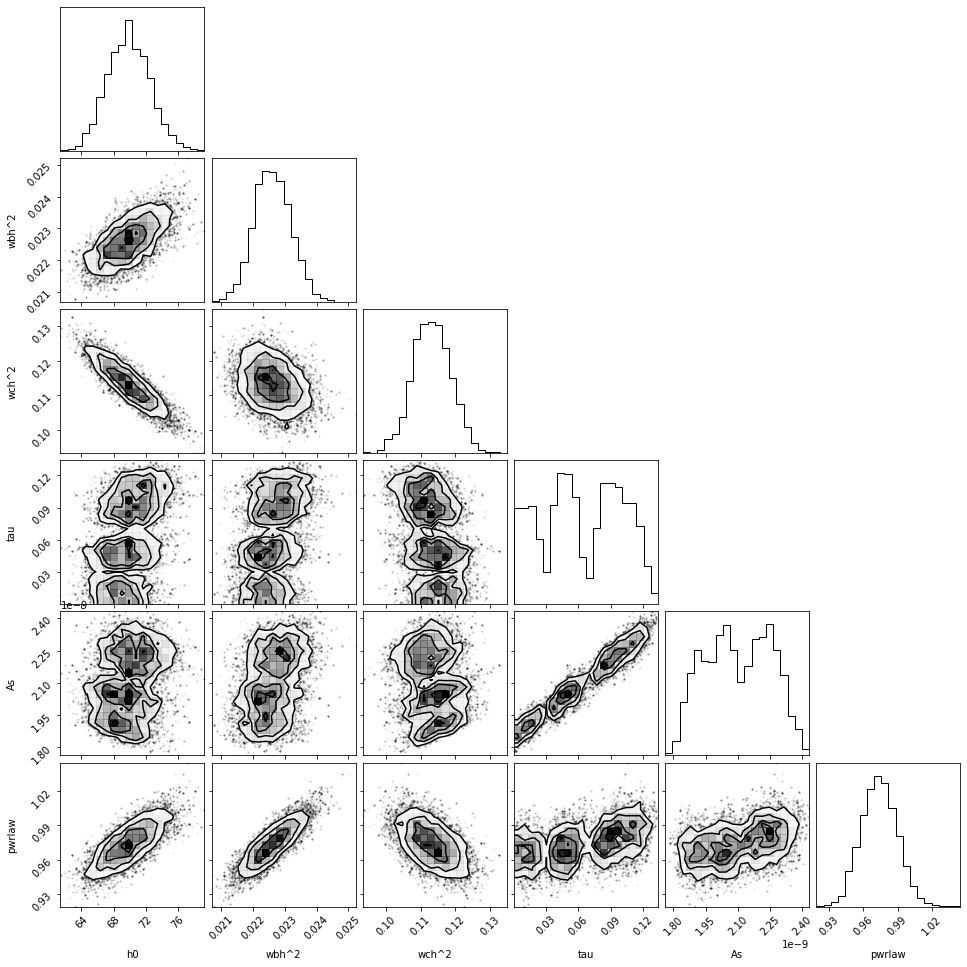

In [10]:
print('corner plot of chain ')
figure = corner.corner(chain, labels=['h0', 'wbh^2', 'wch^2', 'tau', 'As', 'pwrlaw'])

Can see in the corner plot that tau and As have not done well, they are highly correlated and there's a couple discrete spots they like to hang out; they have not converged like the other neat blobs.

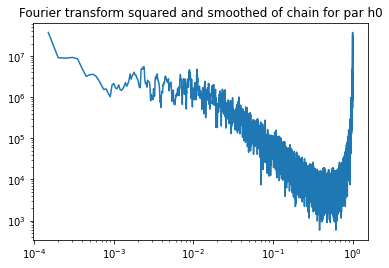

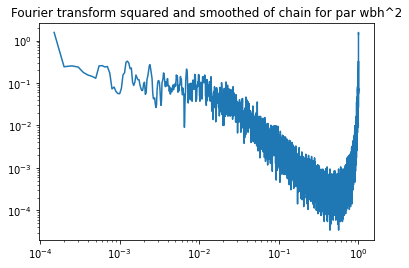

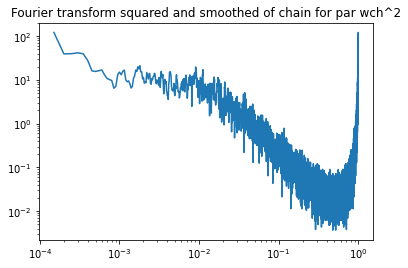

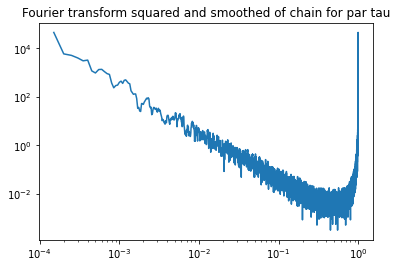

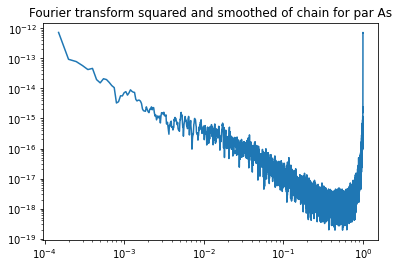

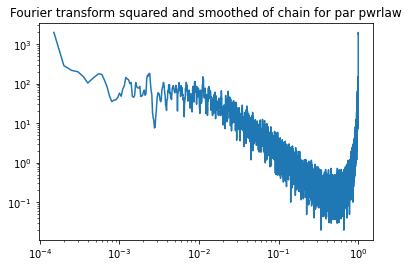

In [11]:
#testing for convergence.
#examine previous plots of parameters versus steps by eye, but also plot fourier transform.

conv = np.fft.fft(chain, axis=0)

labels=['h0', 'wbh^2', 'wch^2', 'tau', 'As', 'pwrlaw']
xnorm = np.arange(0, chain.shape[0])/chain.shape[0]

#plot fourier transform
# for ii in range(chain.shape[1]):
#     mpl.figure()
#     mpl.plot(xnorm, np.abs(conv[:, ii])**2)
#     mpl.xscale('log')
#     mpl.yscale('log')
#     mpl.title('Fourier transform of chain for par ' + labels[ii])
#     if ii in [0, 1, 2, 5]:
#         mpl.ylim([min(np.abs(conv[:, ii])**2), max(np.abs(conv[:, ii])**2)/1000])
#     else:
#         mpl.ylim([min(np.abs(conv[:, ii])**2), max(np.abs(conv[:, ii])**2)/10])
#     mpl.show()
    
#smooth
conv2_smooth = np.copy(conv)
conv2_smooth = np.abs(conv2_smooth)**2
av = 5
for ii in range(chain.shape[1]):
    box = np.ones(av)/float(av)
    conv2_smooth[:, ii] = np.convolve(conv2_smooth[:, ii], box, mode="same")
    
    mpl.figure()
    #smoothing messes up first few data points
    mpl.plot(xnorm[3:], conv2_smooth[3:, ii])
    mpl.xscale('log')
    mpl.yscale('log')
    mpl.title('Fourier transform squared and smoothed of chain for par ' + labels[ii])
#     if ii in [0, 1, 2, 5]:
#         mpl.ylim([min(conv2_smooth[:, ii]), max(conv2_smooth[:, ii])/10])
#     else:
#         mpl.ylim([min(conv2_smooth[:, ii]), max(conv2_smooth[:, ii])/10])
    mpl.show()

Sievers looks at the power spectrum (smooth squared Fourier transform) of the chain to look at convergence. Here we see a distinct knee in most of the power spectrums (except tau and As) at about 0.02, meaning independent samples about one every 50 samples, so for the 20,000 sample run about 400 independent samples, so not bad.

However, tau and As do not have a knee; they have not flattened out on the left side of the power spectrum and are not really converged.

### MCMC Cholesky with all parameters calculated at once for curvature matrix (33k samples)

chain sigmas are  [2.70250010e+00 5.98881396e-04 5.59598042e-03 4.95085364e-02
 2.07539729e-10 1.71585411e-02]
chain means are  [7.04557043e+01 2.26871212e-02 1.11872307e-01 8.61259375e-02
 2.19340160e-09 9.77865014e-01]

 FINAL VALUES: 
final value for par  h0  :  70.45570428244484  error:  2.702500099164502
final value for par  wbh^2  :  0.02268712122806501  error:  0.000598881396376515
final value for par  wch^2  :  0.1118723070663294  error:  0.005595980415948165
final value for par  tau  :  0.08612593745537606  error:  0.049508536359679244
final value for par  As  :  2.193401595448222e-09  error:  2.0753972868338668e-10
final value for par  pwrlaw  :  0.9778650144651113  error:  0.017158541133723868


total count is  2393
length of chain is  33068
acceptance rate is  0.07236603362767631
the acceptance rate of the chain is  0.07236603362767631


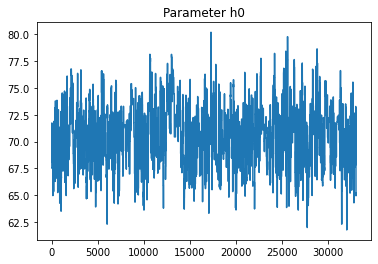

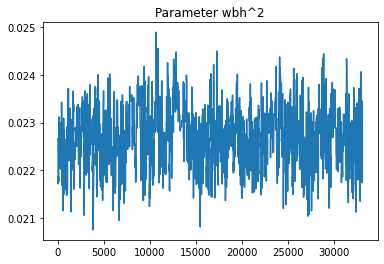

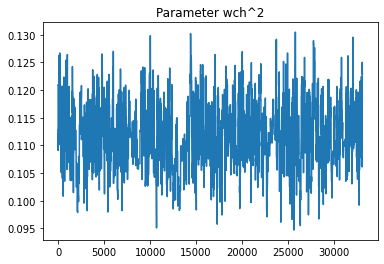

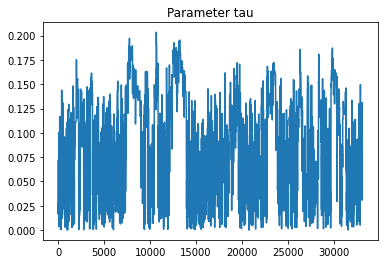

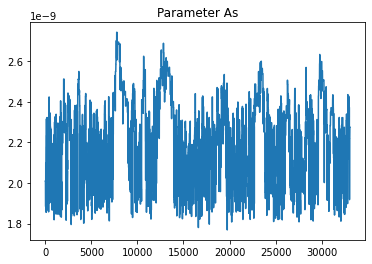

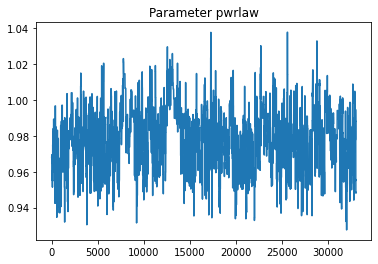

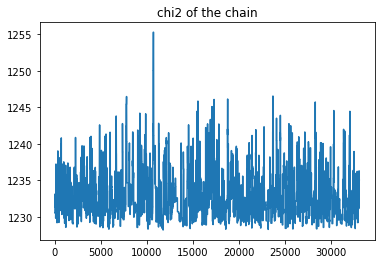

In [12]:
chain = np.loadtxt("chain36k_nozeros.txt")
chi2vec = np.loadtxt("chi2vec36k_nozeros.txt")

chainmeans = np.mean(chain, axis=0)
chainsigs = np.std(chain, axis=0)
print('chain sigmas are ', chainsigs)
print('chain means are ', chainmeans)

par_lab = ['h0', 'wbh^2', 'wch^2', 'tau', 'As', 'pwrlaw']
print('\n FINAL VALUES: ')
for ii in range(chain.shape[1]):
    print('final value for par ', par_lab[ii], ' : ', chainmeans[ii], ' error: ', chainsigs[ii])

print('\n')
print('the acceptance rate of the chain is ', acceptance_rate(chain))

par_lab = ['h0', 'wbh^2', 'wch^2', 'tau', 'As', 'pwrlaw']
for ii in range(len(pars)):
    mpl.figure()
    mpl.plot(chain[:, ii])
    mpl.title('Parameter ' + par_lab[ii])
    mpl.show()
    
mpl.figure()
mpl.plot(chi2vec)
mpl.title('chi2 of the chain')
mpl.show()

Note that there is suspicious looking structure in the last three parameters (tau, As, and the powerlaw coefficient) that make it likely that those are not converged or badly converged. The other parameters seem more random and better behaved.

We also notice here that the value for tau at ~0.08 is farther off the nominal ~0.05 using this version of the cholesky (with the curvature matrix calculated with all parameters at once), than with the other, which has tau ~0.06.

corner plot of chain 


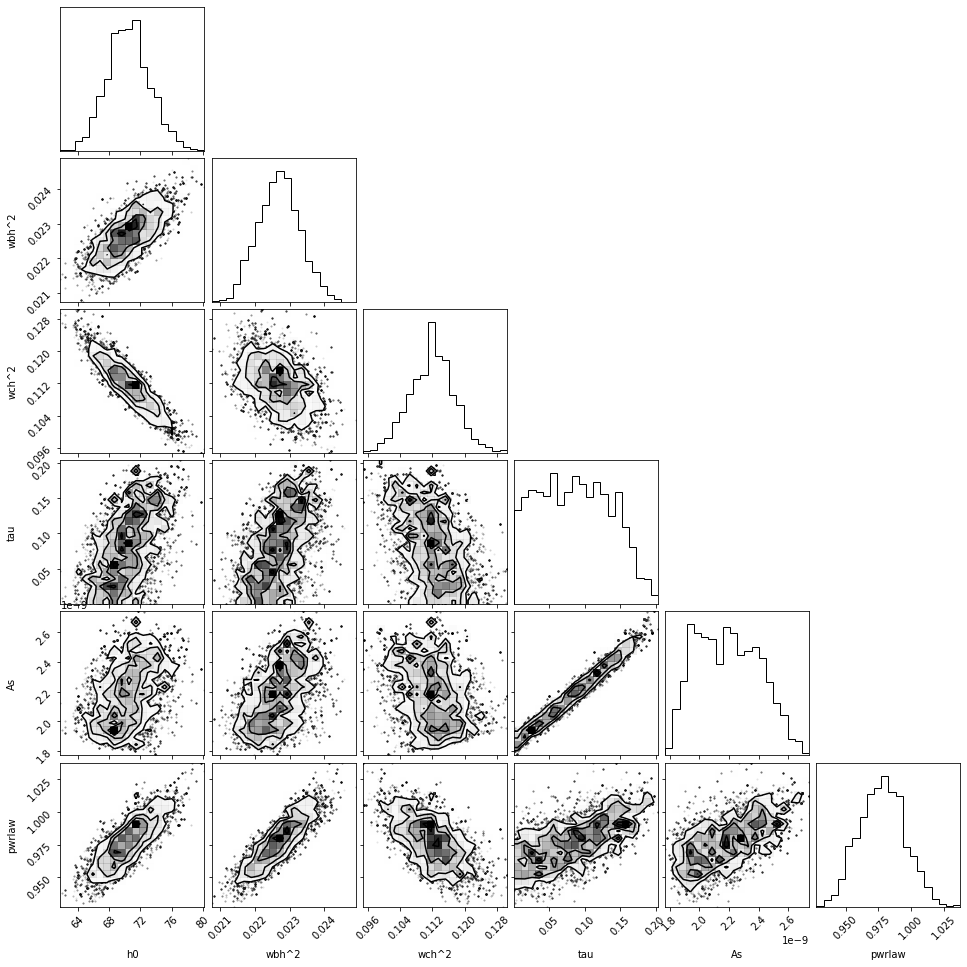

In [13]:
print('corner plot of chain ')
figure = corner.corner(chain, labels=['h0', 'wbh^2', 'wch^2', 'tau', 'As', 'pwrlaw'])

As and tau actually seem to do better in this corner plot, less discrete blobs and more one single blob; highly correlated with eachother.

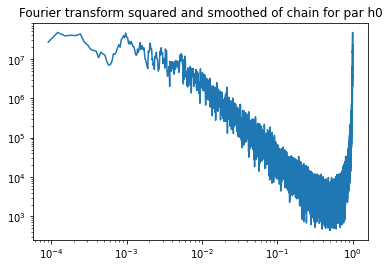

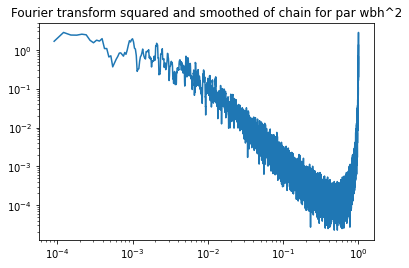

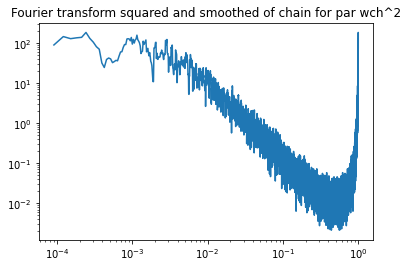

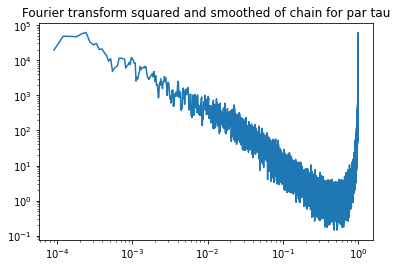

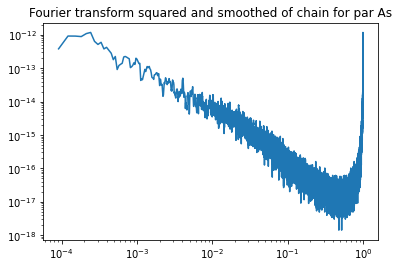

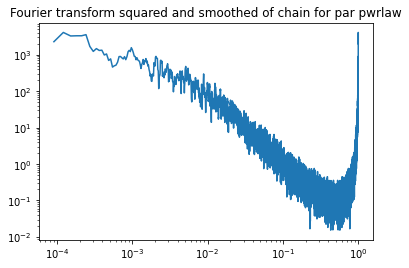

In [14]:
#testing for convergence.
#examine previous plots of parameters versus steps by eye, but also plot fourier transform.

conv = np.fft.fft(chain, axis=0)

labels=['h0', 'wbh^2', 'wch^2', 'tau', 'As', 'pwrlaw']
xnorm = np.arange(0, chain.shape[0])/chain.shape[0]

#plot just fourier transform
# for ii in range(chain.shape[1]):
#     mpl.figure()
#     mpl.plot(xnorm, np.abs(conv[:, ii])**2)
#     mpl.xscale('log')
#     mpl.yscale('log')
#     mpl.title('Fourier transform of chain for par ' + labels[ii])
#     if ii in [0, 1, 2, 5]:
#         mpl.ylim([min(np.abs(conv[:, ii])**2), max(np.abs(conv[:, ii])**2)/1000])
#     else:
#         mpl.ylim([min(np.abs(conv[:, ii])**2), max(np.abs(conv[:, ii])**2)/10])
#     mpl.show()
    
#smooth
conv2_smooth = np.copy(conv)
conv2_smooth = np.abs(conv2_smooth)**2
av = 5
for ii in range(chain.shape[1]):
    box = np.ones(av)/float(av)
    conv2_smooth[:, ii] = np.convolve(conv2_smooth[:, ii], box, mode="same")
    
    mpl.figure()
    #smoothing messes up first few data points
    mpl.plot(xnorm[3:], conv2_smooth[3:, ii])
    mpl.xscale('log')
    mpl.yscale('log')
    mpl.title('Fourier transform squared and smoothed of chain for par ' + labels[ii])
#     if ii in [0, 1, 2, 5]:
#         mpl.ylim([min(conv2_smooth[:, ii]), max(conv2_smooth[:, ii])/10])
#     else:
#         mpl.ylim([min(conv2_smooth[:, ii]), max(conv2_smooth[:, ii])/10])
    mpl.show()

To check for convergence, we look at the left hand side of the power spectrum for the parameters to see whether it is flat or not. We find that the first three parameters, h0, wbh^2 and wch^2 all seem to have some small level of convergence, with a knee at perhaps 0.003 on the x scale (note the normalization to one). So about one in 1/0.003 = 300 points can be considered independent. This is not ideal, as it means that there are really only 100 independent points for those chains in the 33,000 length MCMC run.

The other parameters are a little worse, with the powerlaw coefficient giving an independent sample every approx. 1/0.001 = 1000 points, and As and tau possibly no more than 1/0.0005 = 2000 points, approximated by eyeballing these graphs, so not really converged, or just barely.

In short: the chain has a little badly for some of the parameters, and not at all for others. We can actually guess this simply by looking at the initial graphs of the chain over time: as noted previously the graphs for the powerlaw coefficient, As, and tau all have some suspicious looking structure in them, echoes of which can be seen in the other parameters as well.

To conclude: the better convergence, acceptance rate, and value of tau mean that the first cholesky method, with the curvature matrix calculated for 5 parameters and tau added in after, is the better version.